**Garbage Classification**

In [ ]:
# Unzip The Data Set
!unzip Massive.zip

Archive:  Massive.zip
   creating: content/Massive/
   creating: content/Massive/test/
   creating: content/Massive/test/paper/
  inflating: content/Massive/test/paper/paper142.jpg  
  inflating: content/Massive/test/paper/paper447.jpg  
  inflating: content/Massive/test/paper/paper367.jpg  
  inflating: content/Massive/test/paper/paper68.jpg  
  inflating: content/Massive/test/paper/paper350.jpg  
  inflating: content/Massive/test/paper/paper385.jpg  
  inflating: content/Massive/test/paper/paper356.jpg  
  inflating: content/Massive/test/paper/paper184.jpg  
  inflating: content/Massive/test/paper/paper67.jpg  
  inflating: content/Massive/test/paper/paper274.jpg  
  inflating: content/Massive/test/paper/paper44.jpg  
  inflating: content/Massive/test/paper/paper234.jpg  
  inflating: content/Massive/test/paper/paper360.jpg  
  inflating: content/Massive/test/paper/paper355.jpg  
  inflating: content/Massive/test/paper/paper214.jpg  
  inflating: content/Massive/test/paper/paper544.j

## Model Training

Found 2265 files belonging to 10 classes.
Found 482 files belonging to 10 classes.
Found 496 files belonging to 10 classes.


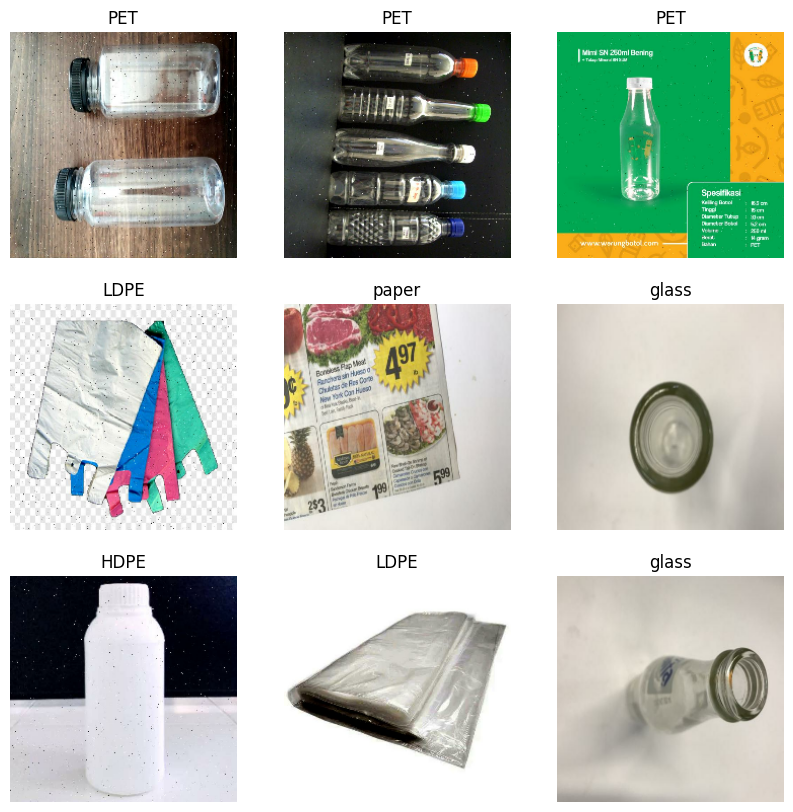

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                

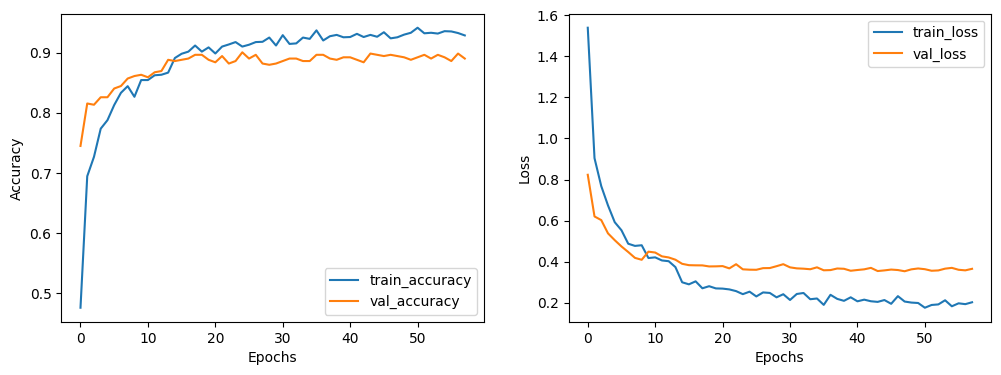

In [ ]:
# Import Library
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define image dimensions and batch size
img_height, img_width = 224, 224  # MobileNetV2 input size
batch_size = 16

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/content/Massive/train",
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/content/Massive/val",
    image_size=(img_height, img_width),
    batch_size=batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/content/Massive/test",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Preprocessing and caching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Class names (adjust based on your dataset)
class_names = ["HDPE", "LDPE", "PET", "PP", "PS", "PVC", "glass", "metal", "other", "paper"]

# Visualize a batch of images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Load MobileNetV2 pretrained on ImageNet, excluding top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
base_model.trainable = False

# Create new top layers for classification
inputs = Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)  # Apply data augmentation
x = tf.keras.layers.Rescaling(1./255)(x)
x = base_model(x, training=False)  # Pass inputs through MobileNetV2 base model
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(128, activation='relu')(x)  # Dense layer
x = Dropout(0.5)(x)  # Dropout layer
outputs = Dense(len(class_names), activation='softmax')(x)  # Output layer with softmax activation

# Compile the model
model = Model(inputs, outputs)
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Confusion Matrix

1/1 [==============================] - 0s 38ms/step


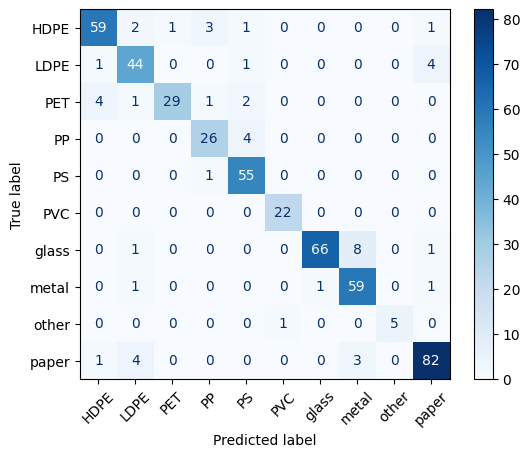

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.show()

## Model Testing

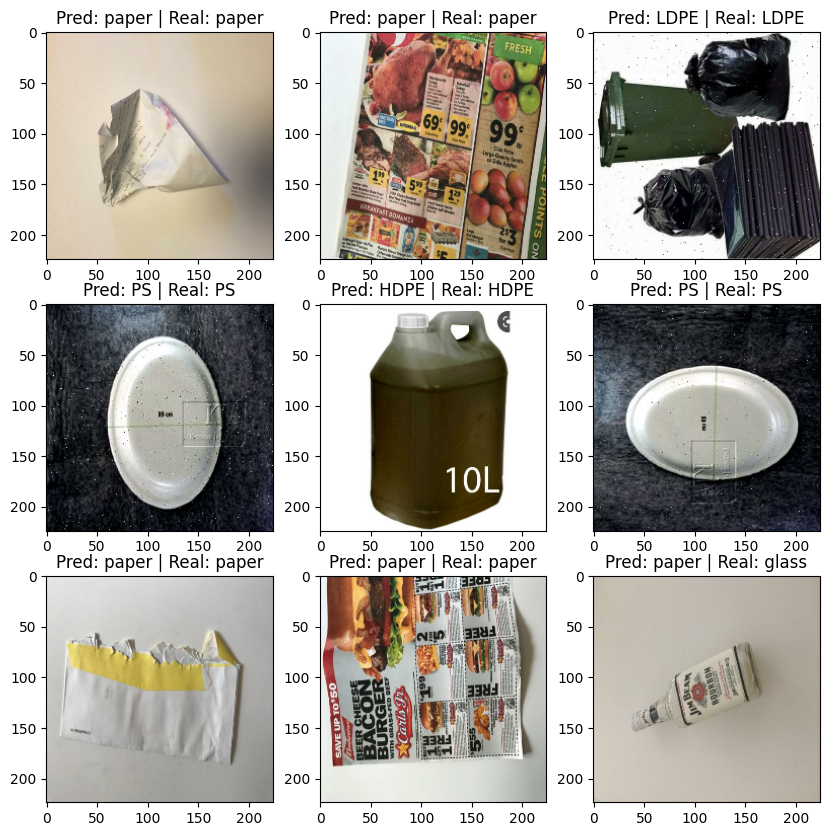

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)


  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [ ]:
model.save("FINAL.keras")
model.save("FINAL.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
